# Spaceship Titanic - Notebook

<!-- TODO -->


Import the necessary libraries. We will use:

- `pandas` to load the data and manipulate it.
- `scikit-learn` to build the model.
<!-- TODO - `matplotlib` and `seaborn` to plot the data. -->


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.svm import SVC
from sklearn.utils.validation import check_is_fitted
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [122]:
# Define constants
CURRENT_DIR = os.getcwd()

DATA_DIR = f"{CURRENT_DIR}/data"
TRAIN_DATA_FILE = f"{DATA_DIR}/train.csv"
TEST_DATA_FILE = f"{DATA_DIR}/test.csv"

TARGET_COLUMN = "Transported"
ID_COLUMN = "PassengerId"

RANDOM_SEED = 42
VALIDATION_SIZE = 0.2

MISSING_VALUE = "Missing"

In [123]:
# Load the data files into pandas dataframes
train_data = pd.read_csv(TRAIN_DATA_FILE)
test_data = pd.read_csv(TEST_DATA_FILE)

In [124]:
# Make PassengerId the index
train_data.set_index(ID_COLUMN, inplace=True)
test_data.set_index(ID_COLUMN, inplace=True)

## Data Exploration


In [ ]:
print("First few rows of data:")
display(train_data.head())

First few rows of data:


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [126]:
print("Data columns and types:")
print(train_data.dtypes)

Data columns and types:
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [ ]:
NUMERICAL_COLUMNS = train_data.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL_COLUMNS = train_data.select_dtypes(include=["object"]).columns.tolist()


leftover_columns = [
    col
    for col in train_data.columns
    if col not in NUMERICAL_COLUMNS
    and col not in CATEGORICAL_COLUMNS
    and col != TARGET_COLUMN
]
assert not leftover_columns

In [128]:
print(f"Numerical columns: {NUMERICAL_COLUMNS}")
print(f"Categorical columns: {CATEGORICAL_COLUMNS}")
print(f"Target column: {TARGET_COLUMN}")

Numerical columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical columns: ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
Target column: Transported


In [129]:
print("\nSummary statistics:")
display(train_data.describe())

print("\nMissing values:")
print(train_data.isnull().sum())

# print("\nCorrelation matrix:")
# sns.heatmap(train_data[NUMERICAL_COLUMNS].corr(), annot=True)
# plt.show()

print("\nValue counts for categorical variables:")
for col in CATEGORICAL_COLUMNS:
    print(f"\n{col} value counts:")
    print(train_data[col].value_counts())


Summary statistics:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



Missing values:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Value counts for categorical variables:

HomePlanet value counts:
HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

CryoSleep value counts:
CryoSleep
False    5439
True     3037
Name: count, dtype: int64

Cabin value counts:
Cabin
G/734/S     8
B/11/S      7
F/1411/P    7
B/82/S      7
G/981/S     7
           ..
G/543/S     1
B/106/P     1
G/542/S     1
F/700/P     1
G/559/P     1
Name: count, Length: 6560, dtype: int64

Destination value counts:
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

VIP value counts:
VIP
False    8291
True      199
Name: count, dtype: int64

Name value counts:
Name
Ankalik Nateansive

In [130]:
train_data

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True


## Clean Dataset

We need to clean the train and test datasets the same way


In [ ]:
def clean_data(data: pd.DataFrame):

    # Convert Cabin to three different columns (Deck, Number, Side)
    data[["CabinDeck", "CabinNumber", "CabinSide"]] = data["Cabin"].str.split(
        "/", expand=True
    )

    # Convert columns to integer (with missing values)
    for col in ["CabinNumber", "CryoSleep", "VIP", "Transported"]:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors="coerce").astype("Int64")

    # Drop columns
    data.drop(columns=["Name", "Cabin"], inplace=True)

    return data

In [132]:
train_data = clean_data(train_data)
test_data = clean_data(test_data)

In [ ]:
def create_features(data: pd.DataFrame):
    data["AmountSpentTotal"] = data[
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    ].sum(axis=1, skipna=True)
    data["AmountSpentMean"] = data[
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    ].mean(axis=1, skipna=True)
    # TODO add more features ?
    return data

In [134]:
train_data = create_features(train_data)
test_data = create_features(test_data)

In [ ]:
handle_missing_values = ColumnTransformer(
    transformers=[
        (
            "cat",
            SimpleImputer(strategy="most_frequent"),
            ["HomePlanet", "Destination", "CabinDeck", "CabinSide"],
        ),
        (
            "num",
            KNNImputer(n_neighbors=5),
            [
                "CryoSleep",
                "Age",
                "VIP",
                "RoomService",
                "FoodCourt",
                "ShoppingMall",
                "Spa",
                "VRDeck",
                "CabinNumber",
                "AmountSpentTotal",
                "AmountSpentMean",
            ],
        ),
    ],
    remainder="passthrough",
    # sparse_threshold=0,
)

# Other numerical inputers
# SimpleImputer(strategy="mean")
# SimpleImputer(strategy="median")
# KNNImputer(n_neighbors=5)

# Other categorical inputers
# SimpleImputer(strategy="most_frequent")
# SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),

# handle_missing_values.set_output(transform="pandas")

## Data Preprocessing Joint Pipeline

### Handle Missing Values

- Input Data
- Mark as "Missing"

- TODO:
  - Look for other inputer strategies

### Data Preprocessing

- Make Categorical Columns Numerical
  - One-Hot encoding
  - Ordinal encoding
- Scale Numerical Columns

- TODO:
  - Other scaling techniques


In [ ]:
# Other numerical inputers
# SimpleImputer(strategy="mean")
# SimpleImputer(strategy="median")
# KNNImputer(n_neighbors=5)


# Combine handling missing values and preprocessing into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat_onehot",
            Pipeline(
                steps=[
                    (
                        "impute",
                        # SimpleImputer(strategy="most_frequent"),
                        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
                    ),
                    (
                        "onehot",
                        OneHotEncoder(),
                        # OrdinalEncoder(),
                        # LabelEncoder(),
                    ),
                ]
            ),
            ["HomePlanet", "Destination"],
        ),
        (
            "cat_ordinal",
            Pipeline(
                steps=[
                    (
                        "impute",
                        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
                        # SimpleImputer(strategy="most_frequent"),
                    ),
                    (
                        "ordinal",
                        OneHotEncoder(),
                        # OrdinalEncoder(),
                        # LabelEncoder(),
                    ),
                ]
            ),
            ["CabinDeck", "CabinSide"],
        ),
        (
            "num",
            Pipeline(
                steps=[
                    (
                        "impute",
                        # KNNImputer(n_neighbors=1),
                        # KNNImputer(n_neighbors=3),
                        KNNImputer(n_neighbors=5),
                        # SimpleImputer(strategy="mean"),
                        # SimpleImputer(strategy="median"),
                    ),
                    (
                        "scale",
                        StandardScaler(),
                        # MinMaxScaler(),
                        # RobustScaler(),
                    ),
                ]
            ),
            [
                "CryoSleep",
                "Age",
                "VIP",
                "RoomService",
                "FoodCourt",
                "ShoppingMall",
                "Spa",
                "VRDeck",
                "CabinNumber",
                "AmountSpentTotal",
                "AmountSpentMean",
            ],
        ),
    ],
    remainder="passthrough",
    # sparse_threshold=0,
)

# preprocessor.set_output(transform="pandas")

In [ ]:
# Fit and transform the train_data using the preprocessor
train_data_transformed = preprocessor.fit_transform(train_data)

# Convert the transformed data back to a DataFrame
train_data_transformed_df = pd.DataFrame(
    train_data_transformed, columns=preprocessor.get_feature_names_out()
)

# Rename columns to remove prefixes
new_column_names = [col.split("__")[-1] for col in train_data_transformed_df.columns]
train_data_transformed_df.columns = new_column_names

### Check Preprocessing Works

- Check if no missing values after preprocessing
- Check if all columns are numerical after preprocessing


In [138]:
# Check for missing values

print("Number of missing values in transformed data:")
display(pd.DataFrame(train_data_transformed_df.isna().sum()).T)

assert train_data_transformed_df.isna().sum().sum() == 0

Number of missing values in transformed data:


,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,Destination_55 Cancri e,Destination_Missing,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,...,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,AmountSpentTotal,AmountSpentMean,Transported
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check all columns are numerical

all_columns_numerical = train_data_transformed_df.select_dtypes(
    include=[np.number]
).columns.tolist()
all_columns = train_data_transformed_df.columns.tolist()

columns_not_numerical = set(all_columns) - set(all_columns_numerical)
print(f"Columns not numerical: {columns_not_numerical}")

assert all_columns_numerical == all_columns

Columns not numerical: set()


## Analyze Correlation on Transformed Dataset


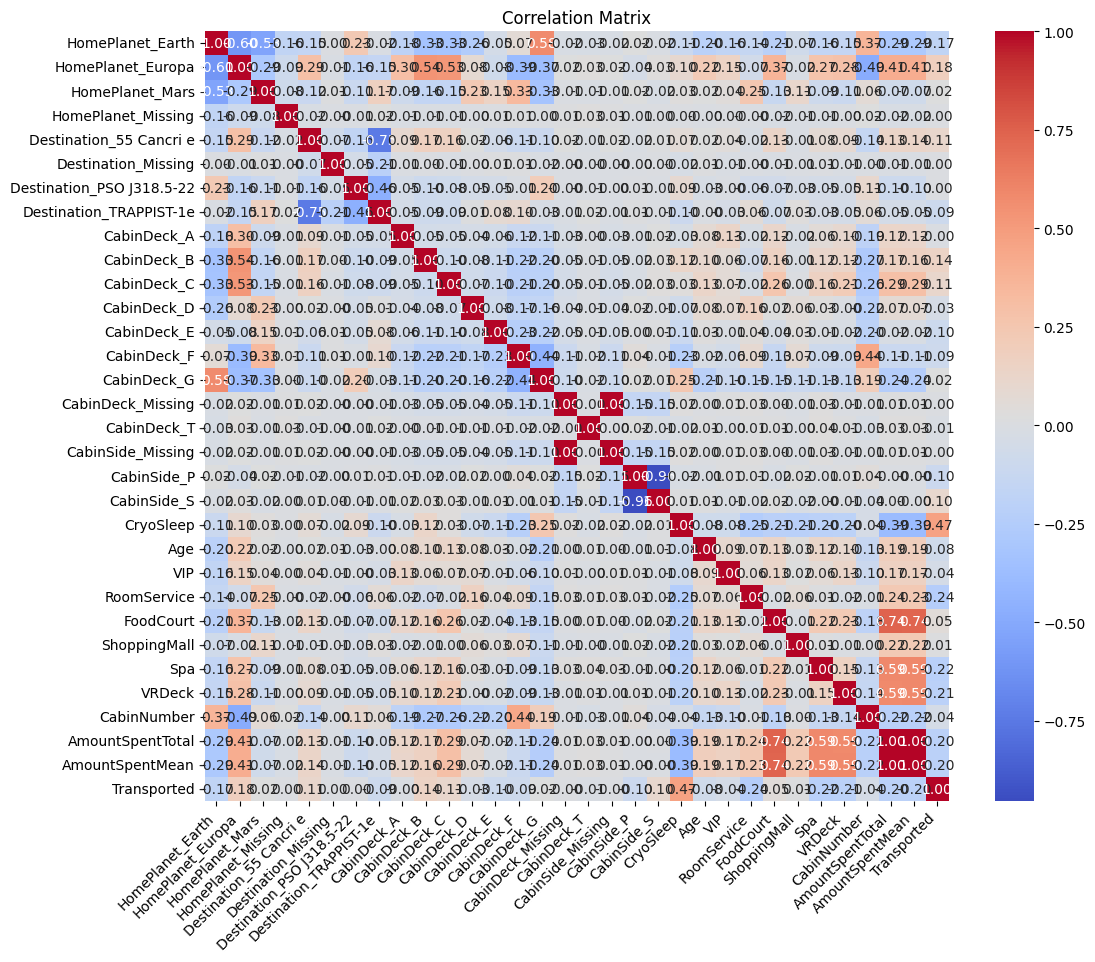

In [ ]:
corr_matrix = train_data_transformed_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    xticklabels=all_columns,
    yticklabels=all_columns,
)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

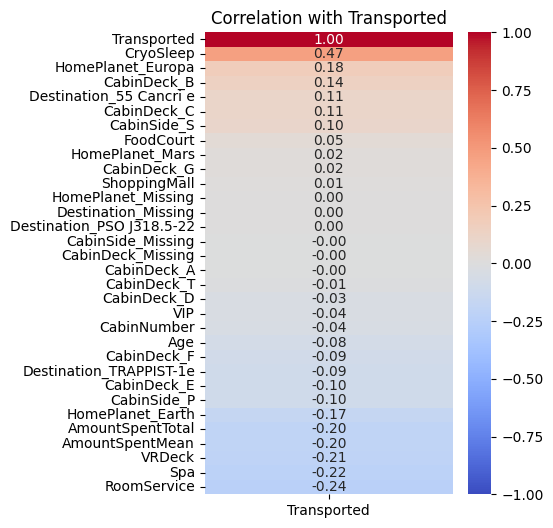

In [141]:
# Filter the correlation matrix to only include the Target Column
target_corr_matrix = corr_matrix[[TARGET_COLUMN]].sort_values(
    by=TARGET_COLUMN, ascending=False
)

plt.figure(figsize=(4, 6))
sns.heatmap(target_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Correlation with {TARGET_COLUMN}")
plt.show()

## Tuning Grids


In [142]:
# Main pipeline

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", "passthrough"),
    ]
)

# Note: "passthrough" is used as a placeholder for the model to be used

### Preprocessor Grids

2 _ 2 _ 5 = 20
Fitting 5 folds for each of 120 candidates, totalling 600 fits
11 min 51 s


In [ ]:
preprocessor_grids = [
    {
        "preprocessor__cat_onehot__impute": [
            # SimpleImputer(strategy="most_frequent"), # 
            SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
        ]
    },
    {
        "preprocessor__cat_onehot__onehot": [
            OneHotEncoder(),
            # OrdinalEncoder(), # 
        ]
    },
    {
        "preprocessor__cat_ordinal__impute": [
            # SimpleImputer(strategy="most_frequent"), # 
            SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
        ]
    },
    {
        "preprocessor__cat_ordinal__ordinal": [
            OneHotEncoder(), # TODO works better?
            # OrdinalEncoder(), #
        ]
    },
    {
        "preprocessor__num__impute": [
            # KNNImputer(n_neighbors=1), # 
            # KNNImputer(n_neighbors=3), # 
            # KNNImputer(n_neighbors=5), # 
            # SimpleImputer(strategy="mean"), # 
            SimpleImputer(strategy="median"),
        ]
    },
    {
        "preprocessor__num__scale": [
            StandardScaler(),
            # MinMaxScaler(), # 
            # RobustScaler(), # 
        ]
    },
]

### Model Grid

6 + 3 + 6 + 6 + 8 = 29
Fitting 5 folds for each of 29 candidates, totalling 145 fits
3 min 45s


In [176]:
model_grids = [
    {
        # Logistic Regression
        "classifier": [LogisticRegression()],
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear", "saga"],
    },
    {
        # Decision Tree
        "classifier": [DecisionTreeClassifier(random_state=RANDOM_SEED)],
        "classifier__max_depth": [None, 10, 20, 30],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
    },
    {
        # Random Forest
        "classifier": [RandomForestClassifier(random_state=RANDOM_SEED)],
        "classifier__n_estimators": [100, 200, 300],
        "classifier__max_depth": [None, 10, 20, 30],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
    },
    {
        # Support Vector Machine
        "classifier": [SVC(probability=True)],
        "classifier__C": [0.01, 0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf", "poly"],
        "classifier__gamma": ["scale", "auto"],
    },
    {
        # Gradient Boosting
        "classifier": [GradientBoostingClassifier(random_state=RANDOM_SEED)],
        "classifier__n_estimators": [100, 250, 500],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7],
        "classifier__subsample": [0.8, 1.0],
    },
    {
        # K-Nearest Neighbors
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [3, 5, 7, 9, 11],
        "classifier__weights": ["uniform", "distance"],
        "classifier__metric": ["euclidean", "manhattan"],
    },
    {
        # XGBoost
        "classifier": [XGBClassifier(random_state=RANDOM_SEED)],
        "classifier__n_estimators": [100, 250, 500],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__max_depth": [3, 6, 9],
        "classifier__subsample": [0.8, 1.0],
        "classifier__colsample_bytree": [0.8, 1.0],
    },
    {
        # LightGBM
        "classifier": [LGBMClassifier(random_state=RANDOM_SEED)],
        "classifier__n_estimators": [100, 250, 500],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__max_depth": [3, 6, 9],
        "classifier__subsample": [0.8, 1.0],
        "classifier__colsample_bytree": [0.8, 1.0],
    },
]

### Final Grid Search


In [182]:
parameter_grids = []

for m in model_grids:
    for p in preprocessor_grids:
        grid = m
        grid.update(p)
        parameter_grids.append(grid)


## Model Training and Parameter Grid Search


In [183]:
# Split the train data into training and validation sets
X = train_data.drop(columns=[TARGET_COLUMN])
y = train_data[TARGET_COLUMN]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VALIDATION_SIZE, random_state=RANDOM_SEED
)

In [ ]:
# Run experiments
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameter_grids,
    cv=5,  # TODO parametrize
    scoring="accuracy",
    verbose=2,
)

grid_search.fit(X_train, y_train)

#### Best so far

```
Best Model:
classifier                                        : GradientBoostingClassifier(random_state=42)
classifier__learning_rate                         : 0.1
classifier__n_estimators                          : 250
preprocessor__cat_onehot__impute                  : SimpleImputer(fill_value='Missing', strategy='constant')
preprocessor__cat_onehot__onehot                  : OneHotEncoder()
preprocessor__cat_ordinal__impute                 : SimpleImputer(fill_value='Missing', strategy='constant')
preprocessor__cat_ordinal__ordinal                : OneHotEncoder()
preprocessor__num__impute                         : SimpleImputer(strategy='median')
preprocessor__num__scale                          : StandardScaler()
```


In [ ]:
# grid_search.best_estimator_
best_params = grid_search.best_params_
print(
    f"Best Model:\n{"\n".join([f"{k:<50}: {v}" for k,v in grid_search.best_params_.items()])}"
)

Best Model:
classifier                                        : GradientBoostingClassifier(random_state=42)
classifier__learning_rate                         : 0.1
classifier__n_estimators                          : 250
preprocessor__cat_onehot__impute                  : SimpleImputer(fill_value='Missing', strategy='constant')
preprocessor__cat_onehot__onehot                  : OneHotEncoder()
preprocessor__cat_ordinal__impute                 : SimpleImputer(fill_value='Missing', strategy='constant')
preprocessor__cat_ordinal__ordinal                : OneHotEncoder()
preprocessor__num__impute                         : SimpleImputer(strategy='median')
preprocessor__num__scale                          : StandardScaler()


In [ ]:
# Save the best model parameters to a file
best_params = grid_search.best_params_
best_params_file = f"{DATA_DIR}/best_params.txt"
with open(best_params_file, "w") as f:
	f.write(str(best_params))

## Best Model Evaluation with Validation Set


In [ ]:
model = grid_search


y_pred = model.predict(X_val)
y_pred_proba = (
    model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
)
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None

print(f"Best Model:\n", grid_search.best_params_)
print(f"Accuracy: {accuracy}")
if roc_auc is not None:
    print(f"ROC AUC: {roc_auc}")
print(classification_report(y_val, y_pred))

Best Model:
 {'classifier': GradientBoostingClassifier(random_state=42), 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 250, 'preprocessor__cat_onehot__impute': SimpleImputer(fill_value='Missing', strategy='constant'), 'preprocessor__cat_onehot__onehot': OneHotEncoder(), 'preprocessor__cat_ordinal__impute': SimpleImputer(fill_value='Missing', strategy='constant'), 'preprocessor__cat_ordinal__ordinal': OneHotEncoder(), 'preprocessor__num__impute': SimpleImputer(strategy='median'), 'preprocessor__num__scale': StandardScaler()}
Accuracy: 0.843588269120184
ROC AUC: 0.9334857227517932
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       861
         1.0       0.83      0.86      0.85       878

    accuracy                           0.84      1739
   macro avg       0.84      0.84      0.84      1739
weighted avg       0.84      0.84      0.84      1739



## Final Model Training and Submission


In [ ]:
# Retrain the best model on the full training data
best_model = grid_search.best_estimator_
best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['HomePlanet',
                                                   'Destination']),
                                                 ('cat_ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OneHotEncoder())]),
                                                  ['CabinDeck', 'CabinSide']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['CryoSleep', 'Age', 'VIP',
                                                   'RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'CabinNumber',
                                                   'AmountSpentTotal',
                                                   'AmountSpentMean'])])),
                ('classifier',
                 GradientBoostingClassifier(n_estimators=250,
                                            random_state=42))])

In [ ]:
# Make predictions on the test data
X_test = test_data
y_pred = best_model.predict(X_test)
test_data[TARGET_COLUMN] = y_pred.astype(bool)

# Make predictions on the test set with the best model
# best_model = max(best_models.items(), key=lambda x: cross_val_score(x[1], X_train, y_train, cv=5).mean())[1]
# test_predictions = best_model.predict(test_data)
# test_data[TARGET_COLUMN] = test_predictions.astype(bool)

In [ ]:
# Create a DataFrame with only the ID_COLUMN and Predictions
predictions_df = test_data.reset_index()[[ID_COLUMN, TARGET_COLUMN]]

# Print predictions
print(predictions_df)

# Save predictions to a CSV file
predictions_df.to_csv(f"{DATA_DIR}/predictions.csv", index=False)

     PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


## TODO

- Exploratory Data Analysis:
  - Data visualization
  - Find missing values
  - Find outliers, extreme or unusual values
  - Correlation analysis between numerical attributes and the target variable
  - For better data fitting, a more detailed analysis of each categorical variable is necessary.
- Data Preparation:
  - Data cleaning
  - Handle: outliers, extreme or unusual values
  - Missing values (removal, transformation, imputation, etc.)
  - Transform categorical variables into numerical (e.g., one-hot encoding)
  - (?) Transform numerical variables into categorical (e.g., discretization)
  - Feature engineering:
    - Create new attributes from existing ones to improve data description and reduce dimensionality.
    - It may also be interesting to create new attributes based on the interaction of highly correlated variables.
  - Feature selection
  - Instance selection
- Model Training:
  - Cross-validation
  - Grid search
- Model Evaluation:
  - Evaluation metrics
  - Model comparison
- Results Presentation:
  - Results visualization
  - Results interpretation


## TODO 2

1. Clean data
   1. [x] Cabin split /
   2. [x] Change types (boolean to int) -> True = 1, False = 0
   3. [x] Class variable "Transported" to int
2. Missing values
   - [ ] Remove
   - [ ] Inpute
     - Categorical:
       - [ ] Mode
       - [ ] Simple
       - [ ] Constant MISSING_VALUE
     - Numerical:
       - [ ] Mean
       - [ ] Median
       - [ ] KNN
3. Feature engineering
   - [ ] Create variable for expenses
   - [ ] Create variable for name bag of words
4. Categorical variables to numerical
   - [ ] One-hot encoding
   - [ ] Ordinal encoding
5. Numerical values scaling
   - [ ] Standardization
   - [ ] Normalization
